In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb

In [2]:
def Gaussian_pdf(mu, sigma, stds=4):
    x = np.linspace(mu - stds*sigma, mu + stds*sigma, 100)
    y = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    return x, y

In [3]:
def get_automatic_range(R_m, V_th, tau_m, omega, I_osc, range_frac=.9):
    A = 1/np.sqrt(1 + (tau_m*omega)**2)
    T = (2*np.pi)/omega
    expon = np.exp(-T/tau_m)
    frac_denom = (1 - expon)*R_m*I_osc*A
    
    I_min = (V_th/frac_denom - 1)*I_osc*A
    I_max = (V_th/frac_denom + 1)*I_osc*A
    
    corr_frac = (1 - range_frac) * (I_max - I_min) / 2
    I_min += corr_frac
    I_max -= corr_frac
    
    return I_min, I_max

In [4]:
def get_average_Is(R_m, V_th, tau_m, omega, I_osc):
    A = 1/np.sqrt(1 + (tau_m*omega)**2)
    T = (2*np.pi)/omega
    expon = np.exp(-T/tau_m)
    frac_denom = (1 - expon)*R_m
    
    I_avg = V_th/frac_denom
    
    return I_avg

In [5]:
def compute_Iosc(v_osc_amp, R_m, tau_m, omega):
    I_osc = abs(v_osc_amp) * np.sqrt((tau_m*omega)**2 + 1) / R_m
    return I_osc

In [6]:
def eta_to_sigma_w(eta, V_th, tau_m):
    return eta * V_th / np.sqrt(tau_m)

In [7]:
def compute_mean_phi(R_m, V_th, tau_m, omega, I_s, I_osc):
    A = 1/np.sqrt(1 + (tau_m*omega)**2)
    ph = -np.arctan(tau_m*omega) - np.pi
    m = I_s/(A*I_osc)
    T = (2*np.pi)/omega
    b = V_th/(R_m*I_osc*A*(1 - np.exp(-T/tau_m)))
    phi = np.nan_to_num(-np.arccos(b - m) - ph)
    return phi

def compute_var_phi(R_m, V_th, eta, tau_m, omega, I_s, I_osc, f):
    phi_i = compute_mean_phi(R_m, V_th, tau_m, omega, I_s, I_osc)
    numerator = omega**2 * eta**2 * V_th**2 * (1 - np.exp(-2/(f*tau_m))) * tau_m**2
    denominator = 2 * (-V_th + R_m * I_s - R_m * I_osc * np.cos(phi_i))**2
    var =  numerator/denominator
    return var

def get_distr(R_m, V_th, eta, tau_m, v_osc_amp, f, N, range_frac):
    omega = 2 * np.pi * f
    I_osc = compute_Iosc(v_osc_amp, R_m, tau_m, omega)
    I_min, I_max = get_automatic_range(R_m, V_th, tau_m, omega, I_osc, range_frac=range_frac)
    Is_range = np.linspace(I_min, I_max, N)
    means = [compute_mean_phi(R_m, V_th, tau_m, omega, I_s, I_osc) for I_s in Is_range]
    variances = [compute_var_phi(R_m, V_th, eta, tau_m, omega, I_s, I_osc, f) for I_s in Is_range]
    return np.array(means), np.array(variances)

In [8]:
# Params
R_m = 142 * 1e6        # MOmh
V_th = 15 * 1e-3       # mV
eta = 0.14             # a.u  //  sigma_w = 0.012-0.015 V/sqrt(s), acoording to Lansky et al (2006). eta=0.124-0.155 a.u.
tau_m = 24 * 1e-3      # ms
f = 5                  # Hz
omega = 2 * np.pi * f  # Hz
v_osc_amp = 5 * 1e-3   # mV
I_osc = compute_Iosc(v_osc_amp, R_m, tau_m, f)
#I_osc = 40 * 1e-12     # pA
N = 5                  # number input levels
range_frac = 0.75
I_min, I_max = get_automatic_range(R_m, V_th, tau_m, omega, I_osc, range_frac)
Is_range = np.linspace(I_min, I_max, N)

#phis_0 = list(map(lambda I_s : compute_mean_phi(R_m, V_th, tau_m, omega, I_s, I_osc), Is_range))

In [9]:
Is_range

array([8.44215346e-11, 9.50403673e-11, 1.05659200e-10, 1.16278033e-10,
       1.26896866e-10])

In [9]:
means, variances = get_distr(R_m, V_th, eta, tau_m, v_osc_amp, f, N, range_frac)

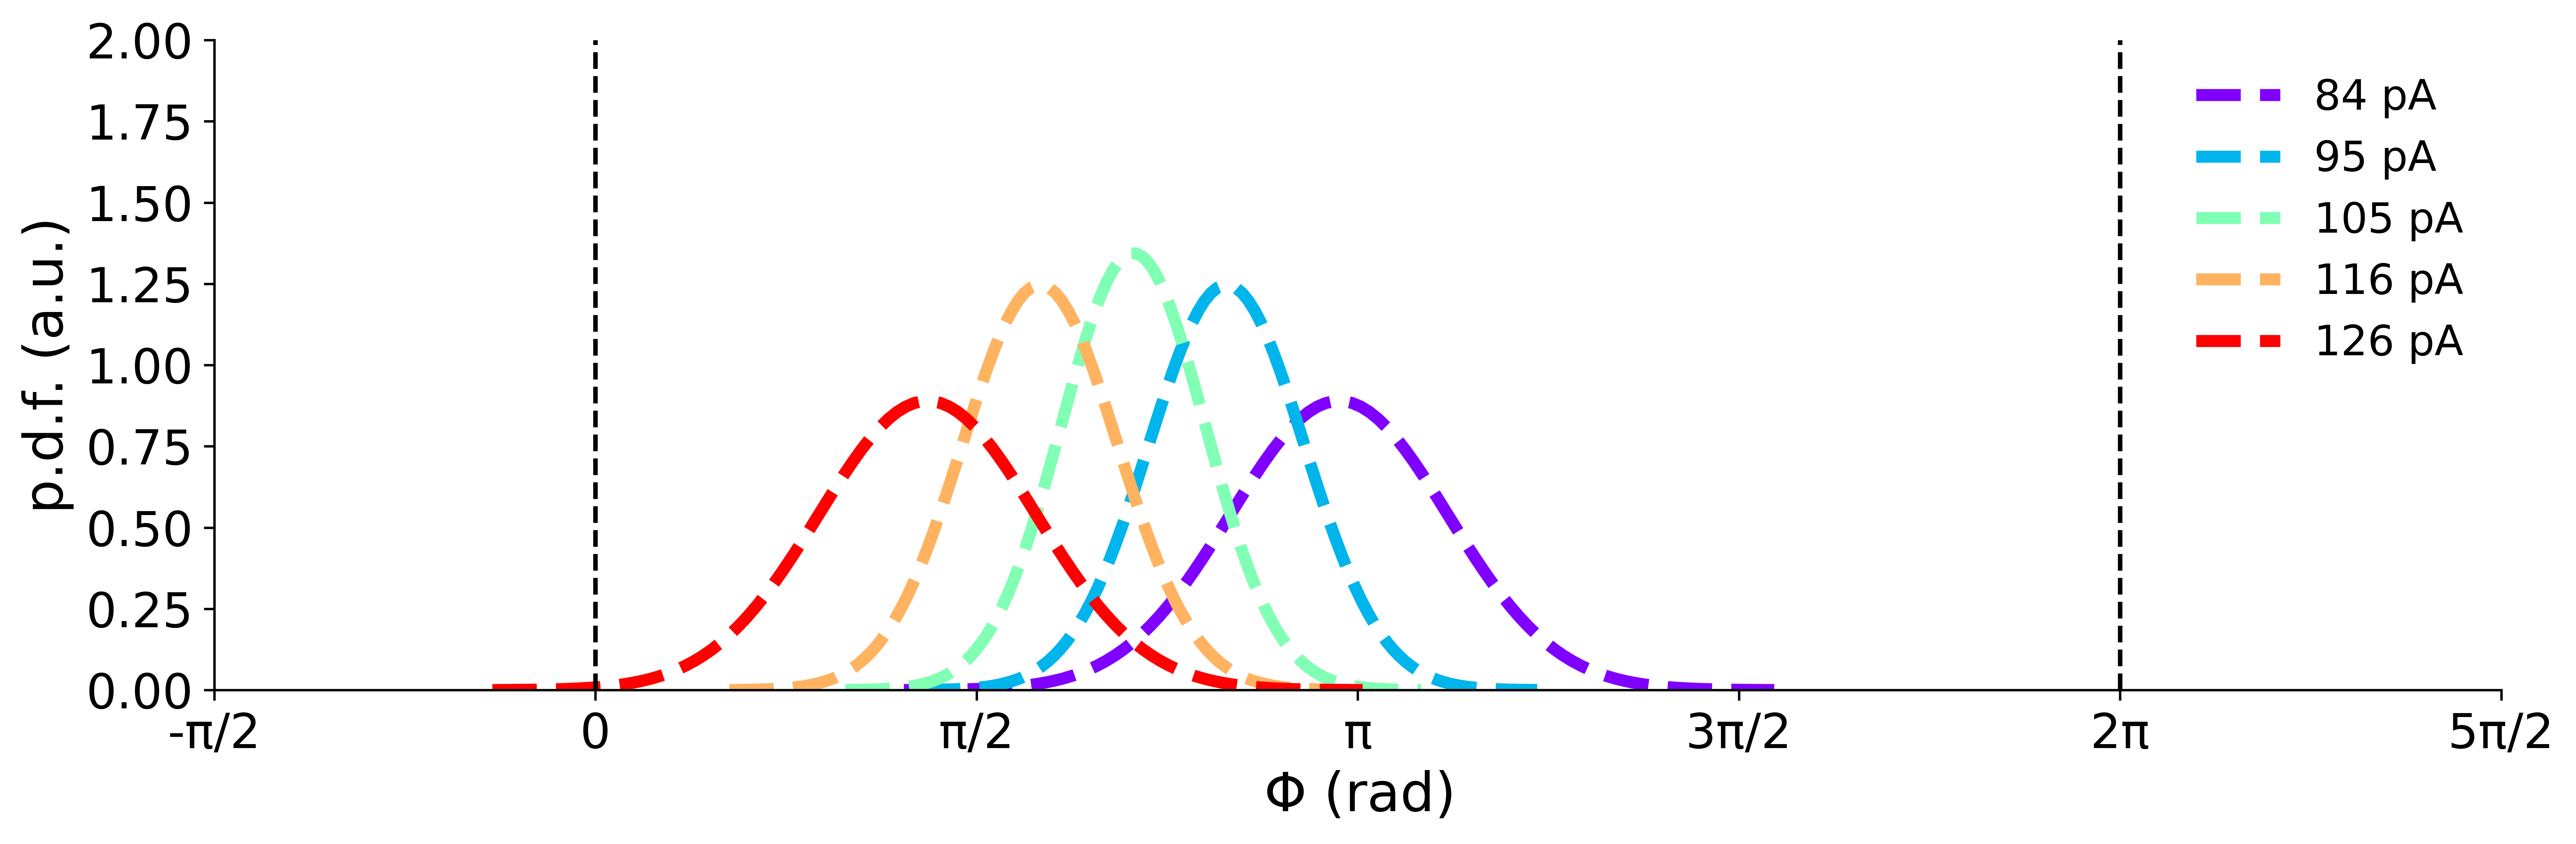

In [10]:
plt.figure(figsize=(12,4), dpi=600)

alphas = np.linspace(0.2, 1, N)
c = cm.rainbow(np.linspace(0, 1, N))

for i, Is in enumerate(Is_range):
    x, y = Gaussian_pdf(means[i], np.sqrt(variances[i]))
    plt.plot(x, y, linewidth=4, linestyle='--', color=c[i], label=str(int(Is*1e12))+" pA")

plt.legend(frameon=False, fontsize=14)
plt.ylabel('p.d.f. (a.u.)', fontsize=18)
plt.xlabel('$\mathit{\Phi}$ (rad)', fontsize=18)
plt.xticks(np.linspace(-np.pi/2, (5/2)*np.pi, 7), ['-π/2', '0', 'π/2', 'π', '3π/2', '2π', '5π/2'], fontsize=16)
plt.xlim(-np.pi/2, (5/2)*np.pi)
plt.ylim(0, 2)
plt.yticks(fontsize=16)

plt.axvline(0, linestyle='--', color='k')
plt.axvline(2*np.pi, linestyle='--', color='k')

sb.despine()
plt.tight_layout()
#plt.savefig('distr.png', dpi=600)
plt.show()

In [12]:
fs = [1, 5, 15, 30]
etas = [0.05, 0.1, 0.2, 0.4]
sigmas_w = eta_to_sigma_w(np.array(etas), V_th, tau_m)
alphas = np.linspace(0.2, 1, N)
c = cm.rainbow(np.linspace(0, 1, N))

plt.figure(figsize=(15,15), dpi=600)
count = 1
for i, eta in enumerate(etas):
    for j, f in enumerate(fs):
        means, variances = get_distr(R_m, V_th, eta, tau_m, v_osc_amp, f, N, range_frac)
        plt.subplot(4,4,count)
        for k, Is in enumerate(Is_range):
            x, y = Gaussian_pdf(means[k], np.sqrt(variances[k]))
            plt.plot(x, y, linewidth=2, linestyle='--', color=c[k], label=str(int(Is*1e12))+" pA")
        
        plt.title(r"$\eta = $" + str(eta) + r", $f = $" + str(f))
        plt.legend(frameon=False, fontsize=8)
        plt.xlabel('$\mathit{\Phi}$ (rad)', fontsize=14)
        plt.xticks(np.linspace(-np.pi/2, (5/2)*np.pi, 7), ['-π/2', '0', 'π/2', 'π', '3π/2', '2π', '5π/2'], fontsize=14)
        #plt.xlim(-np.pi/2, (5/2)*np.pi)
        plt.xlim(0, 2*np.pi)
        plt.ylim(0, 5)
        plt.yticks(fontsize=14)
        sb.despine()
        count+=1
        
plt.tight_layout()

#plt.savefig('phase_distr_th.png', dpi=600)

plt.show()

## Mutual info

In [42]:
from scipy.integrate import quad
from scipy.stats import norm

In [43]:
def approx_mi(means, variances):
    return np.log(np.mean(variances) + np.var(means)) - np.mean(np.log(variances))

def numerical_mi(means, variances):
    def mixture_density(x):
        return sum(norm.pdf(x, m, np.sqrt(v)) for m, v in zip(means, variances))*(1/len(means))

    def mixture_entropy(x):
        p_x = mixture_density(x)
        return -p_x * np.log(p_x) if p_x > 0 else 0

    H_Y, _ = quad(mixture_entropy, -np.inf, np.inf)
    H_Y_given_X = np.mean([-0.5 * np.log(2 * np.pi * np.e * v) for v in variances])
    MI = H_Y - H_Y_given_X
    return MI

In [115]:
N = 10
#tau_x = 200e-3
res = 50
fs = np.linspace(1, 50, res)
etas = np.linspace(0.05, 0.4, res)
info_rate_approx = np.zeros((res,res))
info_rate_numerical = np.zeros((res,res))
for i, eta in enumerate(etas):
    print(i)
    for j, f in enumerate(fs):
        means, variances = get_distr(R_m, V_th, eta, tau_m, I_osc, f, N, range_frac)
        info_rate_approx[i, j] = f * approx_mi(means, variances)
        info_rate_numerical[i, j] = f * numerical_mi(means, variances) # *(1 - np.exp(-(1/(f*tau_x))))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [116]:
info_rate_approx_norm = np.zeros_like(info_rate_approx)  
for index, row in enumerate(info_rate_approx):
    info_rate_approx_norm[index, :] = row/np.max(row)
    
info_rate_numerical_norm = np.zeros_like(info_rate_numerical)
for index, row in enumerate(info_rate_numerical):
    info_rate_numerical_norm[index, :] = row/np.max(row)

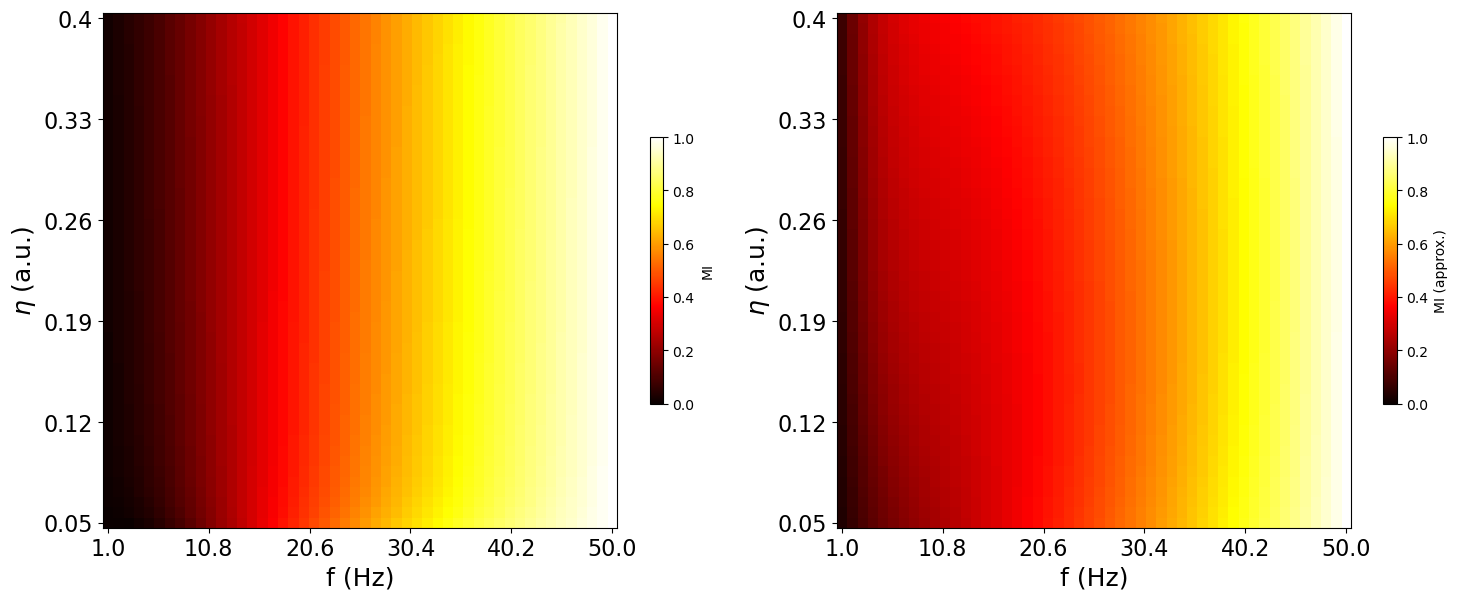

In [119]:
plt.figure(figsize=(15,7))


plt.subplot(121)
plt.imshow(info_rate_numerical_norm, origin='lower', cmap='hot', vmin=0)
plt.xticks(np.linspace(0, res-1, 6), np.linspace(1, 50, 6).round(1), fontsize=16)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(0.05, 0.4, 6).round(3), fontsize=16)
plt.xlabel('f (Hz)', fontsize=18)
plt.ylabel('$\eta$ (a.u.)', fontsize=18)
plt.colorbar(label='MI', shrink=.4)


plt.subplot(122)
plt.imshow(info_rate_approx_norm, origin='lower', cmap='hot', vmin=0)
plt.xticks(np.linspace(0, res-1, 6), np.linspace(1, 50, 6).round(1), fontsize=16)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(0.05, 0.4, 6).round(3), fontsize=16)
plt.xlabel('f (Hz)', fontsize=18)
plt.ylabel('$\eta$ (a.u.)', fontsize=18)
plt.colorbar(label='MI (approx.)', shrink=.4)


plt.tight_layout()
plt.show()

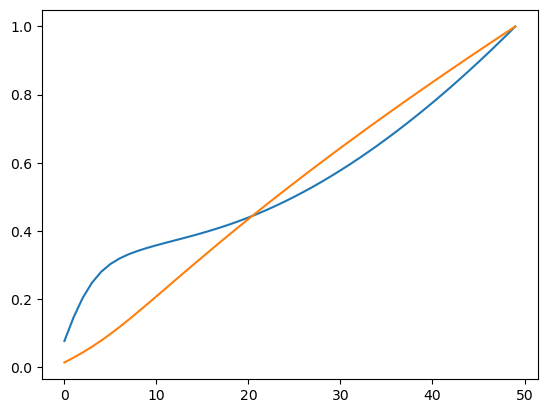

In [145]:
plt.plot(info_rate_approx_norm[-1,:])
plt.plot(info_rate_numerical_norm[-1,:])

## Simulation

In [37]:
def simulate_neurons(R_m, V_th, eta, tau_m, omega, I_s, I_osc, f, N, dt, t, n_neurons):
    V = np.zeros(n_neurons)
    first_spike_phase = np.empty(n_neurons, dtype='object')
    first_spike_phase[:] = None
    phi_0 = compute_mean_phi(R_m, V_th, tau_m, omega, I_s, I_osc)
    sigma_W = eta * V_th / np.sqrt(tau_m)
    for i in range(len(t)):
        xi = np.random.normal(0, 1/np.sqrt(dt), n_neurons)
        I_theta = I_osc * np.cos(omega * t[i] - np.pi + phi_0)
        #I_AHP = amp_AHP * np.exp(-t[i]/tau_AHP)
        dV_dt = (-V + R_m * I_theta + R_m * I_s + tau_m * sigma_W * xi) / tau_m
        V += dV_dt * dt
    
        spiked = V >= V_th
        if np.any(spiked):
            V[spiked] = 0
            if (omega * t[i] - np.pi + phi_0) > np.pi:
                mask = spiked & (first_spike_phase == None)
                first_spike_phase[mask] = (omega * t[i] + phi_0) % (2*np.pi)
                
                if np.all(first_spike_phase != None):
                    break
                
    return first_spike_phase

In [38]:
def get_distr_empirical(R_m, V_th, eta, tau_m, v_osc_amp, f, N, dt, t, num_trials, range_frac):
    omega = 2*np.pi*f
    I_osc = compute_Iosc(v_osc_amp, R_m, tau_m, omega)
    I_min, I_max = get_automatic_range(R_m, V_th, tau_m, omega, I_osc, range_frac=range_frac)
    Is_range = np.linspace(I_min, I_max, N)
    
    means = []
    variances = []
    all_first_spike_phases = []
    for I_s in Is_range:
        first_spike_phases = simulate_neurons(R_m, V_th, eta, tau_m, omega, I_s, I_osc, f, N, dt, t, num_trials)
        first_spike_phases = np.where(first_spike_phases == None, np.nan, first_spike_phases)
        all_first_spike_phases.append(first_spike_phases)  
        means.append( np.nanmean(first_spike_phases) )
        variances.append( np.nanvar(first_spike_phases) )
        
    return np.array(means), np.array(variances), all_first_spike_phases

In [39]:
eta = 0.14             # a.u  //  sigma_w = 0.012-0.015 V/sqrt(s), acoording to Lansky et al (2006). eta=0.124-0.155 a.u.
f = 10  
#I_osc = 40 * 1e-12     # pA
eta = 0.1

# Simulation parameters
dt = 1e-4            # Time step for numerical integration
t_end = 2 / f        # Duration of one cycle
t = np.arange(0, t_end, dt)
num_trials = 1000     # Number of trials

In [40]:
means, variances, all_phis = get_distr_empirical(R_m, V_th, eta, tau_m, v_osc_amp, f, N, dt, t, num_trials, range_frac)

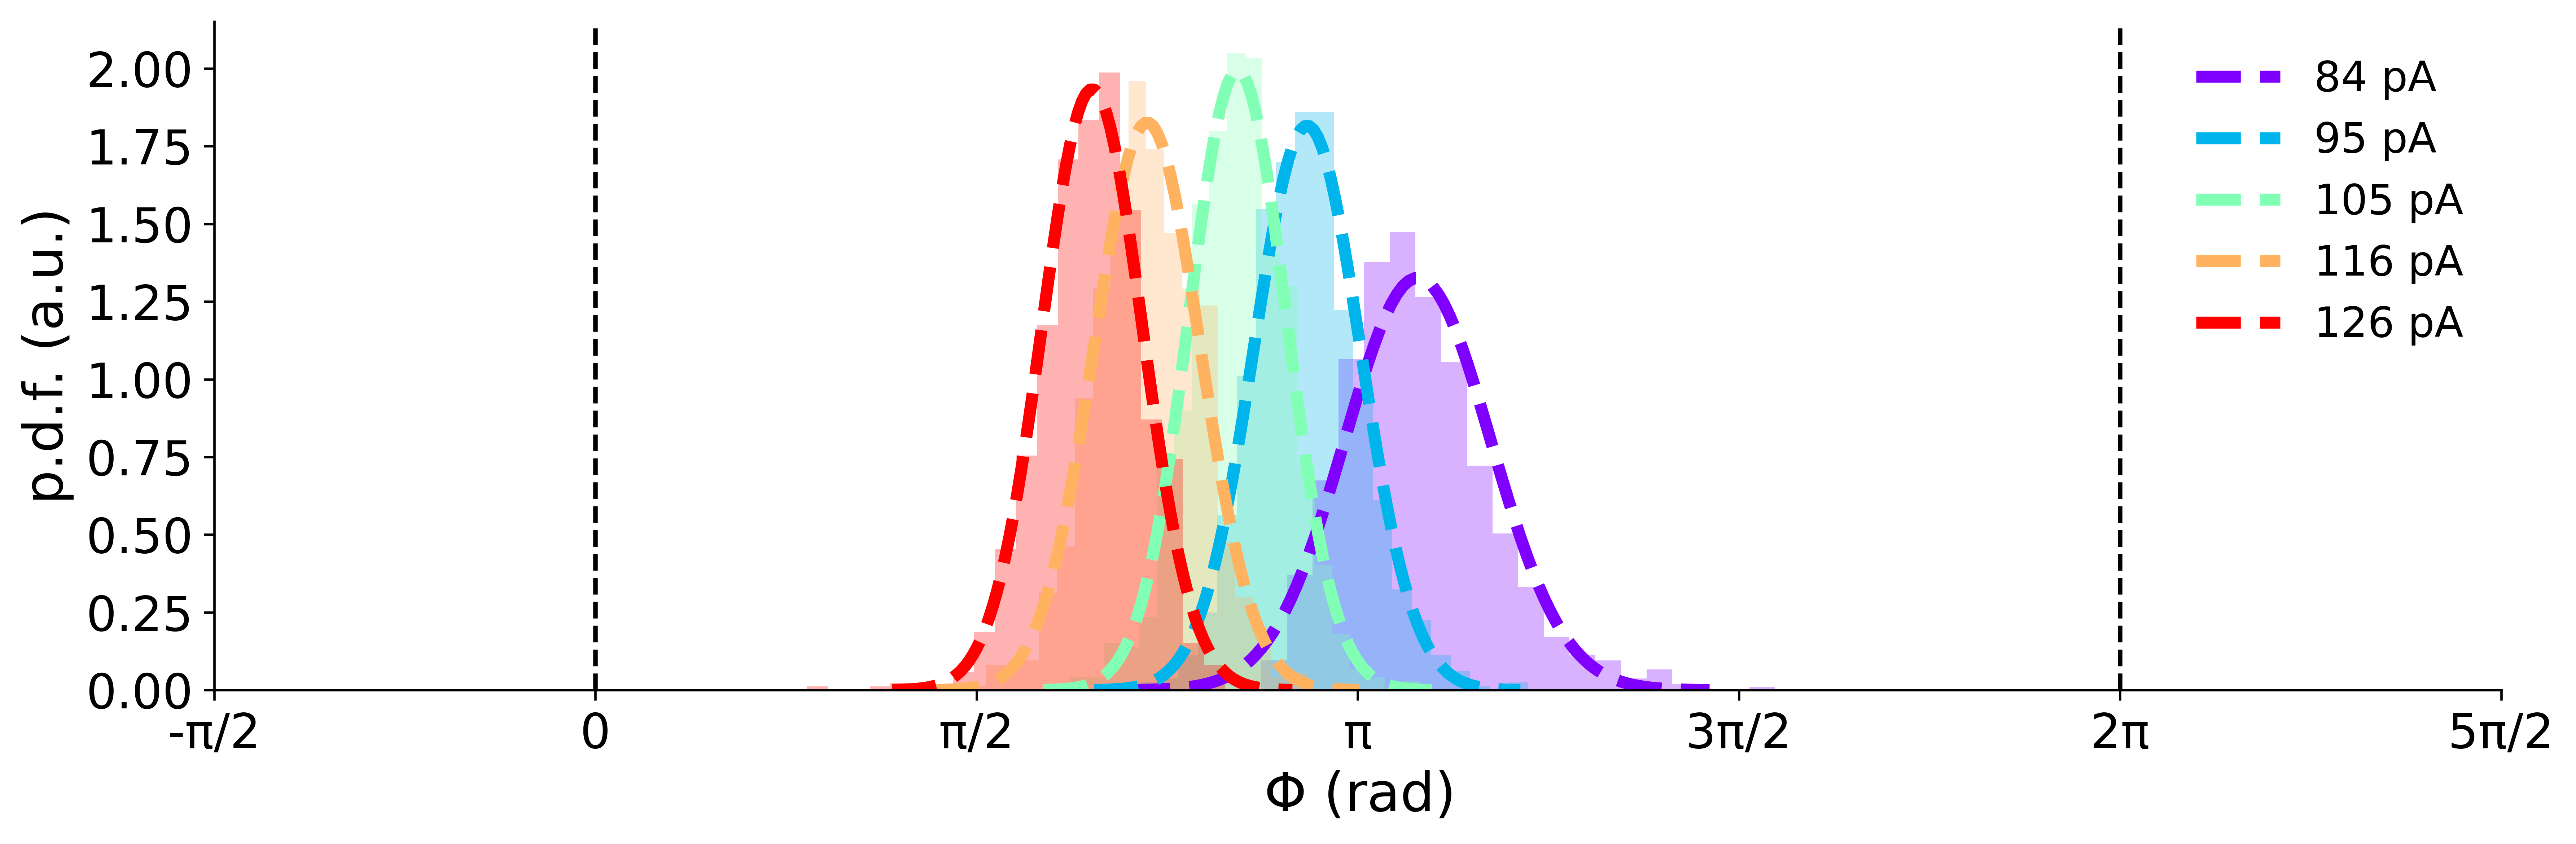

In [41]:
plt.figure(figsize=(12,4), dpi=600)

alphas = np.linspace(0.2, 1, N)
c = cm.rainbow(np.linspace(0, 1, N))

for i, Is in enumerate(Is_range):
    x, y = Gaussian_pdf(means[i], np.sqrt(variances[i]))
    plt.plot(x, y, linewidth=4, linestyle='--', color=c[i], label=str(int(Is*1e12))+" pA")
    plt.hist(all_phis[i], bins=20, density=True, color=c[i], alpha=.3)

plt.legend(frameon=False, fontsize=14)
plt.ylabel('p.d.f. (a.u.)', fontsize=18)
plt.xlabel('$\mathit{\Phi}$ (rad)', fontsize=18)
plt.xticks(np.linspace(-np.pi/2, (5/2)*np.pi, 7), ['-π/2', '0', 'π/2', 'π', '3π/2', '2π', '5π/2'], fontsize=16)
plt.xlim(-np.pi/2, (5/2)*np.pi)
#plt.ylim(0, 2)
plt.yticks(fontsize=16)

plt.axvline(0, linestyle='--', color='k')
plt.axvline(2*np.pi, linestyle='--', color='k')

sb.despine()
plt.tight_layout()
plt.show()

#### Noise-frequency grid

In [171]:
# Simulation parameters
dt = 1e-4            # Time step for numerical integration
num_trials = 1000    # Number of trials
N = 10

In [174]:
res = 50
fs = np.linspace(1, 50, res)
etas = np.linspace(0.05, 0.4, res)
info_rate_empirical_approx = np.zeros((res,res))
info_rate_empirical_numerical = np.zeros((res,res))
for i, eta in enumerate(etas):
    print(i)
    for j, f in enumerate(fs):
        t_end = 2 / f
        t = np.arange(0, t_end, dt)
        means, variances, all_phis = get_distr_empirical(R_m, V_th, eta, tau_m, v_osc_amp, f, N, dt, t, num_trials, range_frac)
        info_rate_empirical_approx[i, j] = f * approx_mi(means, variances)
        info_rate_empirical_numerical[i, j] = f * numerical_mi(means, variances)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [175]:
info_rate_empirical_approx_norm = np.zeros_like(info_rate_empirical_approx)  
for index, row in enumerate(info_rate_empirical_approx):
    info_rate_empirical_approx_norm[index, :] = row/np.max(row)
    
info_rate_empirical_numerical_norm = np.zeros_like(info_rate_empirical_numerical)
for index, row in enumerate(info_rate_empirical_numerical):
    info_rate_empirical_numerical_norm[index, :] = row/np.max(row)

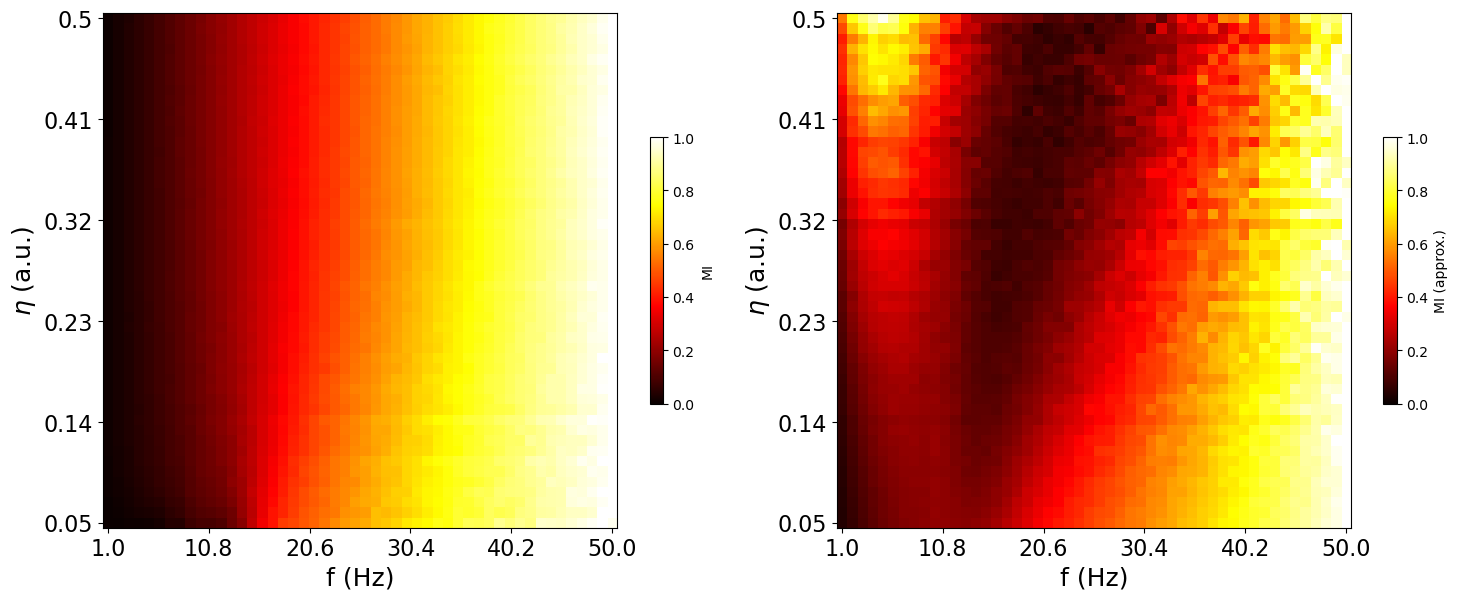

In [176]:
plt.figure(figsize=(15,7))


plt.subplot(121)
plt.imshow(info_rate_empirical_numerical_norm, origin='lower', cmap='hot', vmin=0)
plt.xticks(np.linspace(0, res-1, 6), np.linspace(1, 50, 6).round(1), fontsize=16)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(0.05, 0.4, 6).round(3), fontsize=16)
plt.xlabel('f (Hz)', fontsize=18)
plt.ylabel('$\eta$ (a.u.)', fontsize=18)
plt.colorbar(label='MI', shrink=.4)


plt.subplot(122)
plt.imshow(info_rate_empirical_approx_norm, origin='lower', cmap='hot', vmin=0)
plt.xticks(np.linspace(0, res-1, 6), np.linspace(1, 50, 6).round(1), fontsize=16)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(0.05, 0.4, 6).round(3), fontsize=16)
plt.xlabel('f (Hz)', fontsize=18)
plt.ylabel('$\eta$ (a.u.)', fontsize=18)
plt.colorbar(label='MI (approx.)', shrink=.4)


plt.tight_layout()
#plt.savefig('empirical_mi.png', dpi=600)
plt.show()

## Frequency analysis

In [42]:
def cutoff_frequency(tau_m):
    '''
    Frequency where the power falls to 1/2 (or the amplitude falls to 1/sqrt(2)) of the maximum 
    '''
    return 1 / (2 * np.pi * tau_m)


def amplitude_mem_potential(R_m, I_osc, tau_m, f):
    A = 1 / np.sqrt(1 + (tau_m * 2 * np.pi * f)**2)
    amplitude = R_m * I_osc * A
    return amplitude

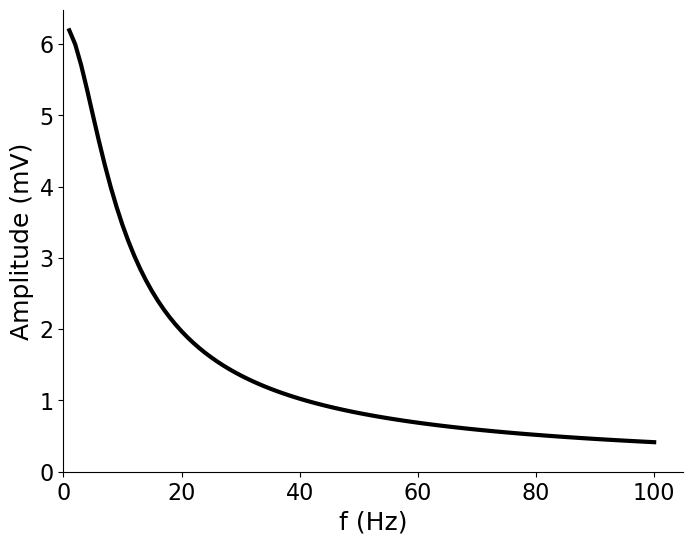

In [19]:
fs = np.linspace(1,100,100)
amp = amplitude_mem_potential(R_m, I_osc, tau_m, fs)

plt.figure(figsize=(8,6))

plt.plot(fs, amp*1e3, color='k', linewidth=3)

#plt.hlines(y=1/np.sqrt(2), xmin=0, xmax=cutoff_frequency(tau_m), linestyle='--', color='r', linewidth=1)

plt.xlabel('f (Hz)', fontsize=18)
plt.ylabel('Amplitude (mV)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0)
plt.xlim(0)

sb.despine()
plt.savefig('amp.png', dpi=600)
plt.show()

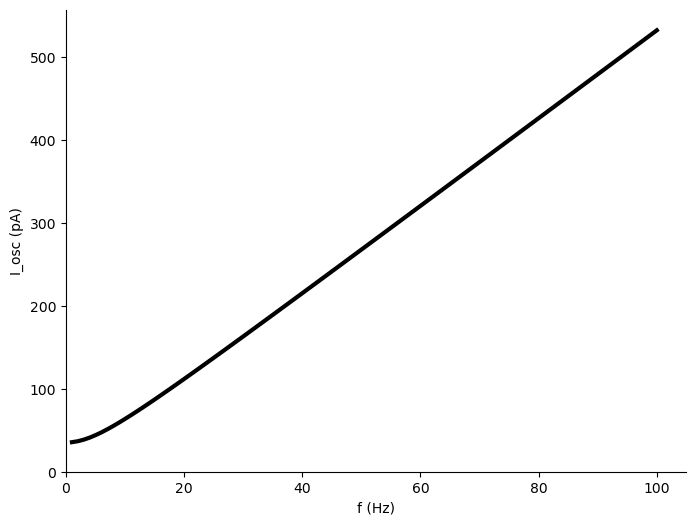

In [179]:
fs = np.linspace(1,100,100)
v_osc_amp = 5 * 1e-3   # mV

I_oscs = compute_Iosc(v_osc_amp, R_m, tau_m, fs)

plt.figure(figsize=(8,6))

plt.plot(fs, I_oscs*1e12, color='k', linewidth=3)

plt.xlabel('f (Hz)')
plt.ylabel('I_osc (pA)')
plt.ylim(0)
plt.xlim(0)

sb.despine()
plt.show()